<h1 align="center">Model Building</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styles
sns.set_palette(sns.color_palette("Set2"))
sns.set_style('whitegrid')

# Feature engineering
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# Models
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance, XGBClassifier

# Validation
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#sklearn output
from sklearn import set_config
set_config(transform_output="pandas")

# Model persistance
from joblib import load, dump

In [2]:
df_cirrhosis = pd.read_csv("../data/cirrhosis.csv")
df_cirrhosis.drop(columns="id", inplace=True)

df_cirrhosis.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
TARGET = "Status"

In [4]:
def split_features(df, target):
    unique_values = df.nunique().drop(target)
    
    cat_features = unique_values[unique_values < 5].index.tolist()
    num_features = unique_values[unique_values >= 5].index.tolist()

    return unique_values, cat_features, num_features

_, CAT_FEATURES, NUM_FEATURES = split_features(df_cirrhosis, TARGET)

## Label Encoding

In [5]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_cirrhosis[TARGET])
        
df_cirrhosis[TARGET] = labels
status_values = df_cirrhosis[TARGET].unique().tolist()
print("Status values:", status_values)

Status values: [2, 0, 1]


## Feature Engineering

### Extra Features

In [6]:
def diagnosis_date(X):
    X["Diagnosis_Date"] = X["Age"] - X["N_Days"]
    return X

def age_years(X):
    X["Age_Years"] = round(X["Age"] / 365.25).astype("int16")
    return X

In [7]:
EXTRA_COLUMNS = ["Diagnosis_Date", "Age_Years"]

### Feature Encoding

Después de analizar nuestros features categóricos, podemos sacar las siguientes conclusiones:

- Las features Drug, Sex, Ascites, Hepatomegaly, Spiders al ser categóricas podemos aplicarles un Binary-Encoding.
- Stage indica las distintas etapas de la condición del paciente, es decir, posee un orden específico. Por lo tanto, sería adecuado utilizar Ordinal-Encoding.
- Se aplicará un StandardScaler a las features numéricas para estandarizarlas y hacerlas comparables en la misma escala.

In [8]:
one_hot_encoder = ColumnTransformer([
    (
        "one_hot_encoder",
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ["Edema"]
    )
], remainder="drop", verbose_feature_names_out=False)

In [9]:
ordinal_encoder = ColumnTransformer([
    (
        "ordinal_encoder",
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        [
            "Drug",
            "Sex",
            "Ascites",
            "Hepatomegaly",
            "Spiders",
            "Stage"
        ]
    )
], remainder="drop", verbose_feature_names_out=False)

In [10]:
standard_scaler = ColumnTransformer([
    (
        "scaler",
        StandardScaler(),
        NUM_FEATURES + EXTRA_COLUMNS
    )
], remainder="drop", verbose_feature_names_out=False)

## Feature Engineering Pipeline

In [11]:
def format_column_names(df):
    columns = df.columns
    format_columns = [col.split("__")[1] for col in columns]

    return format_columns

Después de aplicar los pipelines, se añade un prefijo a los nombres de nuestras columnas. El propósito de esta función es eliminarlos

In [12]:
extra_features_pipeline = Pipeline([
    ("age_years", FunctionTransformer(diagnosis_date, validate=False)),
    ("diagnosis_date", FunctionTransformer(age_years, validate=False)),
])

In [13]:
feature_encoding_pipeline = Pipeline([
    (
        "features",
        FeatureUnion(
            [                
                ("scaler", standard_scaler),
                ("ohe", one_hot_encoder),
                ("ordinal", ordinal_encoder),
            ], 
        ),
    )
])

In [14]:
feature_engineering_pipeline = Pipeline([
    ("extra_features", extra_features_pipeline),
    ("feature_encoding", feature_encoding_pipeline)
])

## Split Data

In [15]:
# Calcular el tamaño de los conjuntos de prueba y validación:
original_count = len(df_cirrhosis)
training_size = 0.60
test_size = (1 - training_size) / 2

training_count = int(original_count * training_size)
test_count = int(original_count * test_size)
validation_count = original_count - training_count - test_count

print("Tamaño del conjunto de entrenamiento:", training_count)
print("Tamaño del conjunto de prueba:", test_count)
print("Tamaño del conjunto de validación:", validation_count)
print("Tamaño del conjunto original:", original_count)

Tamaño del conjunto de entrenamiento: 4743
Tamaño del conjunto de prueba: 1581
Tamaño del conjunto de validación: 1581
Tamaño del conjunto original: 7905


In [16]:
X = df_cirrhosis.drop(columns="Status")
y = df_cirrhosis["Status"]

X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=training_count)
X_test, X_valid, y_test, y_valid = train_test_split(X_rest, y_rest, train_size=test_count)

### Transform Data

In [17]:
X_train = feature_engineering_pipeline.fit_transform(X_train)
X_train.columns = format_column_names(X_train)

X_valid = feature_engineering_pipeline.fit_transform(X_valid)
X_valid.columns = format_column_names(X_valid)

In [18]:
X_train.head()
X_train.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Diagnosis_Date', 'Age_Years', 'Edema_N', 'Edema_S', 'Edema_Y', 'Drug',
       'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Stage'],
      dtype='object')

## Model Training

### Model Selection

In [19]:
def validate_models(models, X, y, n_splits=5, n_repeats=1):
    models_performance = []
    
    for model in models:   
        model_name = model.__class__.__name__
        train_scores, val_scores = [], []
    
        skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
        
        for (train_idx, val_idx) in skf.split(X, y):            
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
                
            train_preds = model.predict_proba(X_train)
            valid_preds = model.predict_proba(X_val)
            
            train_score = log_loss(y_train, train_preds)
            val_score = log_loss(y_val, valid_preds)
            
            train_scores.append(train_score)
            val_scores.append(val_score)

        avg_train_score = np.mean(train_scores)
        avg_val_score = np.mean(val_scores)
        
        models_performance.append({
            "Model": model_name, 
            "Avg train score": avg_train_score, 
            "Avg val score": avg_val_score,
        })
                                 
    return pd.DataFrame(models_performance)


<h4>¿Cómo validamos los modelos?</h4>

1. **RepeatedStratifiedKFold** para dividir nuestros datos en pliegues estratificados y tener una validación cruzada robusta.

2. **predict_proba** para obtener las probabilidades de cada clase en nuestros conjuntos de entrenamiento y validación.

3. **log loss** para evaluar qué tan bien nuestros modelos pueden predecir las probabilidades correctas de las clases. Menor pérdida logarítmica significa mejor rendimiento.

4. promedio de los puntajes de log loss para cada modelo en los conjuntos de entrenamiento y validación.

5. DataFrame que resume el rendimiento de cada modelo en ambos conjuntos de datos.


In [20]:
%%time

xgb_model = XGBClassifier(objective="multi_logloss")
random_forest_model = RandomForestClassifier(criterion="log_loss")

# Machine Learning Models (MLA)
MLA = [
    # XGB
    xgb_model,

    # Ensemble
    random_forest_model,
]

models_performace = validate_models(MLA, X_train, y_train, n_splits=10, n_repeats=1)
models_performace

CPU times: user 21 s, sys: 106 ms, total: 21.1 s
Wall time: 9.88 s


,Model,Avg train score,Avg val score
0,XGBClassifier,0.043846,0.571866
1,RandomForestClassifier,0.118486,0.540240


In [21]:
y_pred = xgb_model.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8184693232131562

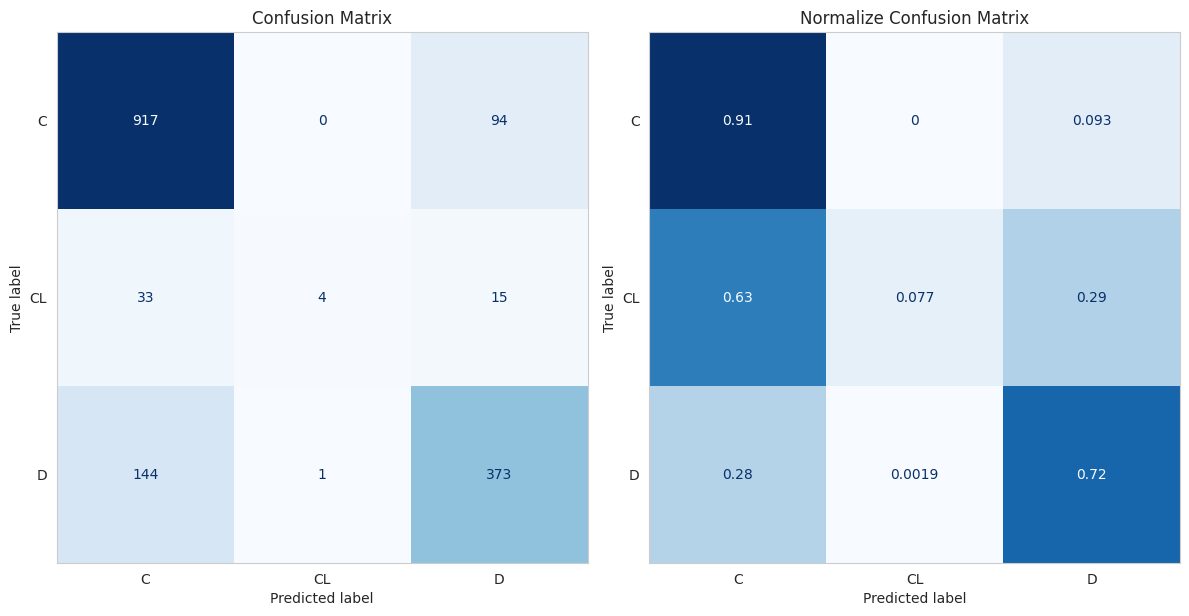

In [22]:
def plot_confusion_matrix(y_true, y_pred, labels, cmap=plt.cm.Blues):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    cm = confusion_matrix(y_true, y_pred)  
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_display.plot(ax=ax1, cmap=cmap, colorbar=False)
    ax1.grid(False)
    ax1.set_title("Confusion Matrix")

    cm_normalize = confusion_matrix(y_true, y_pred, normalize="true")  
    cm_display_normalize = ConfusionMatrixDisplay(confusion_matrix=cm_normalize, display_labels=labels)
    cm_display_normalize.plot(ax=ax2, cmap=cmap, colorbar=False)
    ax2.grid(False)
    ax2.set_title("Normalize Confusion Matrix")

    plt.tight_layout()


labels = ["C", "CL", "D"]
plot_confusion_matrix(y_valid, y_pred, labels)
plt.show()

### Model Pipeline

In [23]:
# Get not modified data
def get_clean_data():
    clean_cirrhosis = pd.read_csv("../data/cirrhosis.csv")
    X = clean_cirrhosis.drop(columns=["Status"])

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(clean_cirrhosis["Status"])

    return X, y

X, y = get_clean_data()

In [24]:
model_pipeline = Pipeline([
    ("data-proccessing", clone(feature_engineering_pipeline)),
    ("model", XGBClassifier(objective="multi_logloss"))
])

X, y = get_clean_data()

model_pipeline.fit(X, y)

Pipeline(steps=[('data-proccessing',
                 Pipeline(steps=[('extra_features',
                                  Pipeline(steps=[('age_years',
                                                   FunctionTransformer(func=<function diagnosis_date at 0x7ff70e082c00>)),
                                                  ('diagnosis_date',
                                                   FunctionTransformer(func=<function age_years at 0x7ff70e082b60>))])),
                                 ('feature_encoding',
                                  Pipeline(steps=[('features',
                                                   FeatureUnion(transformer_list=[('scaler',
                                                                                   ColumnTran...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### Model Testing

In [25]:
y_pred_test = model_pipeline.predict_proba(X_test)
y_pred_test

array([[4.2556569e-02, 7.0346915e-04, 9.5673996e-01],
       [9.6252978e-01, 4.6072551e-03, 3.2862995e-02],
       [9.5092171e-01, 1.5451115e-02, 3.3627190e-02],
       ...,
       [9.9905235e-01, 8.0741534e-05, 8.6691952e-04],
       [9.7820777e-01, 6.5582944e-04, 2.1136384e-02],
       [1.5912296e-01, 6.9943519e-04, 8.4017760e-01]], dtype=float32)

In [26]:
status_labels = ["Status_C", "Status_CL", "Status_D"]

prob = pd.DataFrame(
    {**dict(zip(status_labels, y_pred_test.T))}
)
prob.head()

,Status_C,Status_CL,Status_D
0,0.042557,0.000703,0.956740
1,0.962530,0.004607,0.032863
2,0.950922,0.015451,0.033627
3,0.333747,0.010233,0.656021
4,0.822941,0.005272,0.171787


In [27]:
X_test_reset = X_test.reset_index(drop=True)
prob_reset = prob.reset_index(drop=True)

df_result = pd.concat([X_test_reset, prob_reset], axis=1)
df_result.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Diagnosis_Date,Age_Years,Status_C,Status_CL,Status_D
0,1413,Placebo,16154,F,N,Y,Y,N,17.4,1775.0,...,165.85,97.0,418.0,11.9,4.0,14741,44,0.042557,0.000703,0.956740
1,1690,D-penicillamine,15105,F,N,N,N,N,0.9,604.0,...,170.50,119.0,236.0,10.9,3.0,13415,41,0.962530,0.004607,0.032863
2,1576,Placebo,12641,F,N,Y,N,S,1.3,344.0,...,86.80,92.0,298.0,11.0,3.0,11065,35,0.950922,0.015451,0.033627
3,1420,Placebo,12120,F,N,N,N,N,2.5,382.0,...,153.45,133.0,156.0,10.0,4.0,10700,33,0.333747,0.010233,0.656021
4,1216,Placebo,19470,F,N,Y,Y,N,3.6,347.0,...,220.10,90.0,129.0,11.5,3.0,18254,53,0.822941,0.005272,0.171787


### Model persistance

In [28]:
dump(model_pipeline, "../models/inference_pipeline.joblib")

['../models/inference_pipeline.joblib']